In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import pmdarima as pm


In [5]:
np.random.seed(10)

# 36 months data (3 years)
dates = pd.date_range(start="2022-01-01", periods=36, freq="MS")

# Trend + seasonality + noise
trend = np.linspace(120, 240, 36)
seasonality = 18 * np.sin(np.arange(36) * 2 * np.pi / 12)
noise = np.random.normal(0, 6, 36)

sales = trend + seasonality + noise

df = pd.DataFrame({"Sales": sales}, index=dates)

print(df.head())


                 Sales
2022-01-01  127.989519
2022-02-01  136.720245
2022-03-01  133.173198
2022-04-01  148.235411
2022-05-01  153.030759


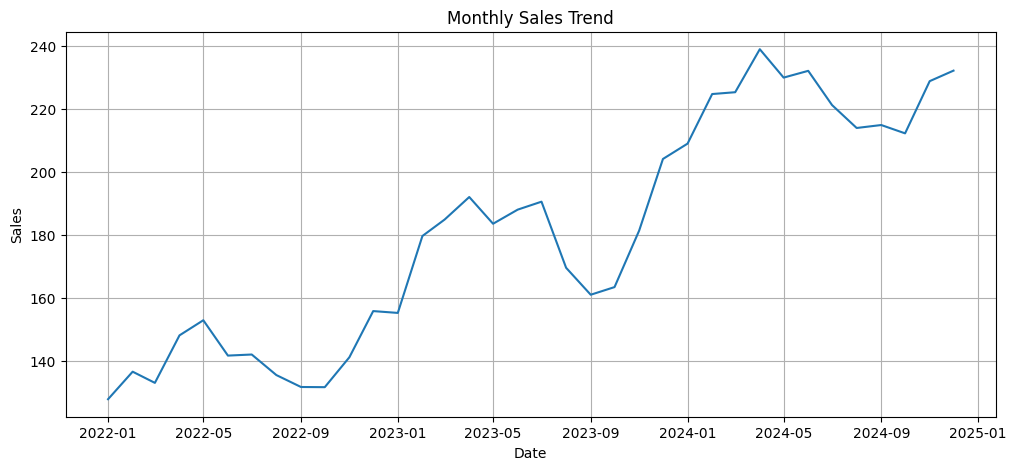

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df["Sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


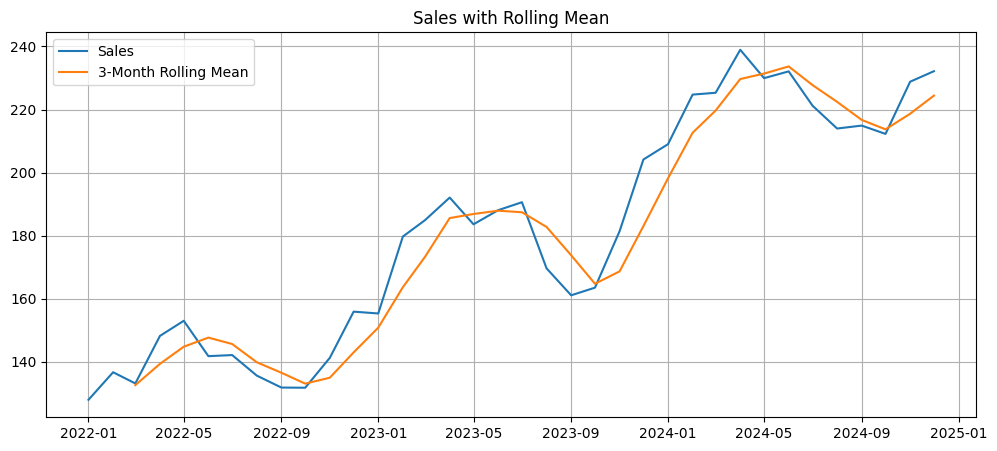

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df["Sales"], label="Sales")
plt.plot(df["Sales"].rolling(3).mean(), label="3-Month Rolling Mean")
plt.title("Sales with Rolling Mean")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    
    if result[1] <= 0.05:
        print("Stationary data")
    else:
        print("Not stationary data")

adf_test(df["Sales"])


ADF Statistic: 0.18066820351943777
p-value: 0.9711562493013441
Not stationary data


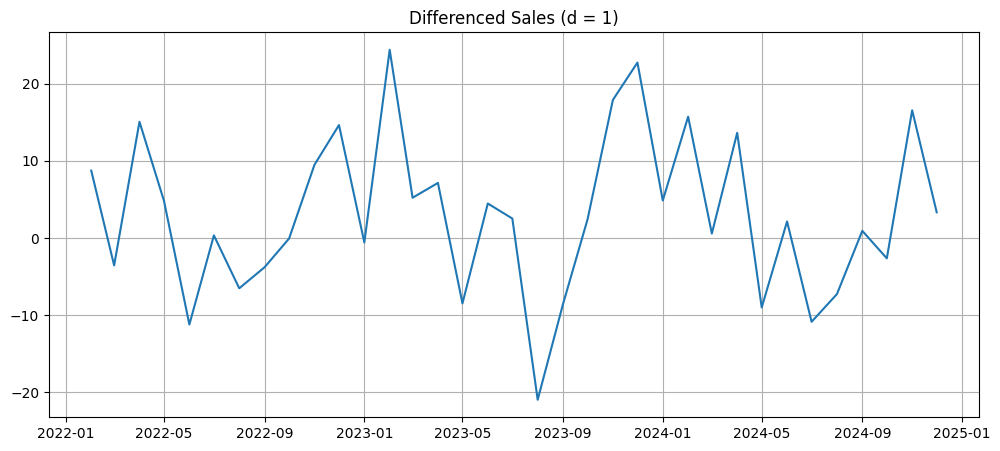

ADF Statistic: -3.8225888118361993
p-value: 0.0026844755837414557
Stationary data


In [11]:
df["Sales_diff"] = df["Sales"].diff()

plt.figure(figsize=(12,5))
plt.plot(df["Sales_diff"])
plt.title("Differenced Sales (d = 1)")
plt.grid(True)
plt.show()

adf_test(df["Sales_diff"].dropna())


In [12]:
ts = df["Sales"]

train = ts.iloc[:-3]
test = ts.iloc[-3:]

print("Train size:", len(train))
print("Test size:", len(test))
print("\nTest data:\n", test)


Train size: 33
Test size: 3

Test data:
 2024-10-01    212.286005
2024-11-01    228.833810
2024-12-01    232.170080
Freq: MS, Name: Sales, dtype: float64


In [13]:
auto_model = pm.auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    trace=True,
    suppress_warnings=True
)

print("\nBest ARIMA Order:", auto_model.order)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=244.398, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=245.438, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=245.719, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=244.528, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=247.157, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.293 seconds

Best ARIMA Order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -120.199
Date:                Sun, 18 Jan 2026   AIC                            244.398
Time:                        15:38:15   BIC                            247.329
Sample:                    01-01-2022   HQIC                          

In [14]:
order = auto_model.order

model = ARIMA(train, order=order)
fitted_model = model.fit()

print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   33
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -121.264
Date:                Sun, 18 Jan 2026   AIC                            244.528
Time:                        15:38:38   BIC                            245.994
Sample:                    01-01-2022   HQIC                           245.014
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       114.5655     30.116      3.804      0.000      55.539     173.592
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.30   Pr

In [15]:
forecast_result = fitted_model.get_forecast(steps=3)

forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

print("Forecasted Sales:\n", forecast_mean)
print("\nConfidence Interval:\n", forecast_ci)


Forecasted Sales:
 2024-10-01    214.922078
2024-11-01    214.922078
2024-12-01    214.922078
Freq: MS, Name: predicted_mean, dtype: float64

Confidence Interval:
             lower Sales  upper Sales
2024-10-01   193.943554   235.900603
2024-11-01   185.253964   244.590192
2024-12-01   178.586208   251.257948


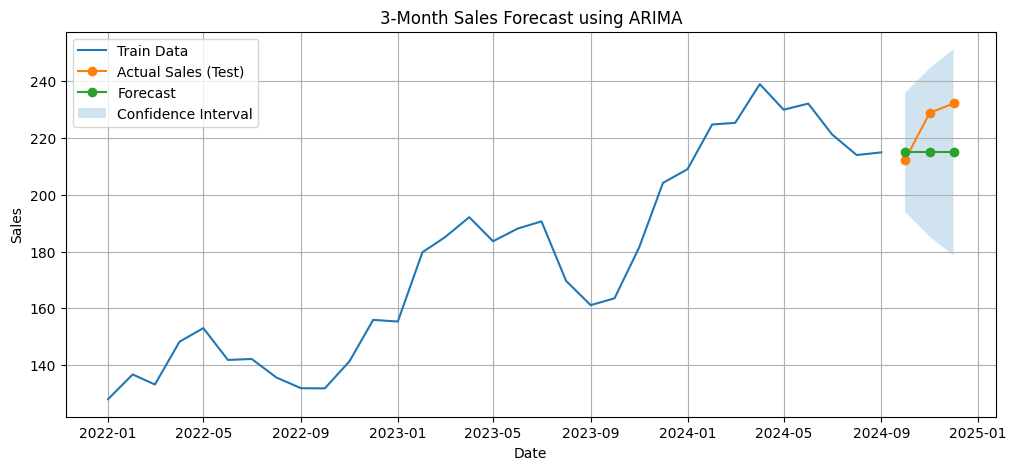

In [16]:
plt.figure(figsize=(12,5))

plt.plot(train, label="Train Data")
plt.plot(test, label="Actual Sales (Test)", marker="o")
plt.plot(forecast_mean, label="Forecast", marker="o")

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="Confidence Interval"
)

plt.title("3-Month Sales Forecast using ARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


In [18]:
mae = mean_absolute_error(test, forecast_mean)

mape = np.mean(np.abs((test - forecast_mean) / test)) * 100

print("MAE:", mae)
print("MAPE:", mape, "%")


MAE: 11.26526872995648
MAPE: 4.916732186452219 %


In [19]:
print("-------- FINAL SUMMARY --------")
print("Model Used: ARIMA", order)
print("\nNext 3 Months Forecast:")
print(forecast_mean)

print("\nEvaluation Results:")
print("MAE:", mae)
print("MAPE:", mape, "%")


-------- FINAL SUMMARY --------
Model Used: ARIMA (0, 1, 0)

Next 3 Months Forecast:
2024-10-01    214.922078
2024-11-01    214.922078
2024-12-01    214.922078
Freq: MS, Name: predicted_mean, dtype: float64

Evaluation Results:
MAE: 11.26526872995648
MAPE: 4.916732186452219 %
